In [2]:
pip install transformers pytorch-pretrained-bert

     |████████████████████████████████| 573kB 4.6MB/s 
     |████████████████████████████████| 133kB 18.9MB/s 
     |████████████████████████████████| 1.0MB 19.0MB/s 
     |████████████████████████████████| 3.7MB 37.0MB/s 
     |████████████████████████████████| 890kB 53.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=dcfd2ec3b94520c296d1d20e3a2a2ab274fbb807648538432e346c65b1c87ab4
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [1]:
import torch 

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from pytorch_pretrained_bert import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2, output_attentions=False, output_hidden_states=False)

model.cuda()

optimizer = AdamW(model.parameters(), 
                lr=2e-5, # learning rate, default = 5e-5
                eps=1e-8 # adam_epsilon, default = 1e-8
                )

In [0]:
import numpy as np
import time
import datetime

# Helper function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Helper function for formatting elapsed times
def format_time(elapsed):
  '''
  Takes a time in seconds and returns a string in format hh:mm:ss
  '''
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [29]:
# Load the training sentences
print('Loading the training data...')

import pandas as pd

CSV_FILE_PATH = './drive/My Drive/Colab Notebooks/diploma_data/begunci_islamofobija_final.csv'
df = pd.read_csv(CSV_FILE_PATH, delimiter=',', header=None, names=['comment', 'label'])

print('Number of comments: {:,}\n'.format(df.shape[0]))
df.sample(5)

Loading the training data...
Number of comments: 6,545



,comment,label
3616,Naj si jih peljejo domov!,1
233,Neeeeeeeeeeeee!!,1
2291,"proga je dvosmerna, mar ne",1
4563,-*-*-*- pazi trnovsek da te nebo ozmerjal da s...,0
5397,boli me za to ....vidim al ne vidim !!!! bolje...,1


In [30]:
import gc

comments = df.comment.values
labels = df.label.values

# Tokenize all of the comments and map the tokens to their word IDs
input_ids=[]
input_labels=[]

for i,comment in enumerate(comments):
  # (1) Tokenize the comment.
  # (2) Prepend the '[CLS]' token to the start and append the '[SEP]' token to the end
  # (3) Map tokens to their IDs

  if isinstance(comment, float):
    continue

  tokenized_comment = tokenizer.tokenize(comment)
  tokenized_comment.insert(0, '[CLS]')
  tokenized_comment.append('[SEP]')

  if len(tokenized_comment) > 512:
    continue
  
  comment_ids = tokenizer.convert_tokens_to_ids(tokenized_comment)
  input_ids.append(comment_ids)
  input_labels.append(labels[i])
  
# Print the comment 0, now as a list of IDs
print('Original: ', comments[0])
print('Token IDs: ', input_ids[0])

# Delete the comments and labels so I free memory
del comments
del labels
gc.collect()

Original:  "V azilnih centrih v Nemčiji že prihaja do številnih posilstev žensk in otrok. Nekatere ženske so s strani mož prisiljene v prostitucijo. Ženske so prestrašene in ne upajo prijavljati te zločine, kar je razumljivo glede na to, da ne razumejo, da je njihova zaščita v Evropi neprimerno večja kot je bila v njihovi državi.

No, takšna kultura prihaja k nam. Naši rezidentni humanisti bi rekli "Dobrodošli"."
Token IDs:  [101, 107, 159, 10360, 11030, 12465, 64286, 10237, 190, 34817, 15515, 10775, 11700, 12377, 100488, 10149, 51770, 44082, 63094, 39327, 38308, 70623, 107042, 11478, 10106, 16694, 10174, 119, 19416, 82574, 10246, 107042, 11275, 10380, 187, 30289, 46912, 13208, 24085, 11030, 37989, 190, 11284, 11964, 10991, 51580, 119, 371, 66688, 10380, 12229, 19975, 31872, 10112, 10106, 10554, 10741, 44543, 12377, 10320, 32865, 10325, 10361, 194, 10715, 50297, 117, 25085, 10144, 20710, 10465, 93060, 58405, 10132, 10114, 117, 10143, 10554, 20710, 20467, 11039, 117, 10143, 10144, 55887

5105

In [31]:
from keras.preprocessing.sequence import pad_sequences

MAX_LENGTH = 505 # Maximum sentence length in slovenian, croatian and english dataset

print('Padding/truncating all the sentences to %d values...' % MAX_LENGTH)

input_ids = pad_sequences(input_ids, maxlen=MAX_LENGTH, dtype='long', value=0, truncating='post', padding='post')

Padding/truncating all the sentences to 505 values...


In [0]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import StepLR

BATCH_SIZE = 8 # Can not be larger (16, 32), because the GPU does not have enough memory

attention_masks = []
for cmnt in input_ids:
  att_mask = [int(token_id > 0) for token_id in cmnt]
  attention_masks.append(att_mask)

# size of training set is 80%, validation is 20% -> we split the validation to 10% for validation set and 10% for test set
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, input_labels, random_state=420, test_size=0.2) # random_state makes sure that the splitting is always the same
validation_inputs, test_inputs, validation_labels, test_labels = train_test_split(validation_inputs, validation_labels, random_state=420, test_size=0.5) # 0.5 * 0.2 = 0.1

train_masks, validation_masks, _, validation_masks_labels = train_test_split(attention_masks, input_labels, random_state=420, test_size=0.2)
validation_masks, test_masks, _, _ = train_test_split(validation_masks, validation_masks_labels, random_state=420, test_size=0.5)

train_data = TensorDataset(torch.tensor(train_inputs), torch.tensor(train_masks), torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(torch.tensor(validation_inputs), torch.tensor(validation_masks), torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

test_data = TensorDataset(torch.tensor(test_inputs), torch.tensor(test_masks), torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

# Create the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [33]:
# Training loop
import random

# Set the seed value everywhere so I can make the results reproducible
SEED_VAL = 42

random.seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)

print('Number of training comments: {:,}'.format(len(train_inputs)))
print('Number of validation comments: {:,}'.format(len(validation_inputs)))

# Save the average loos after each epoch so I can plot them
loss_values = []
accuracy_values = []

epoch = 0
num_of_lower_accuracies = 0
trained_model = None
while True:
  ####################
  #     Training     #
  ####################
  print('')
  print('===== Epoch {:} ====='.format(epoch + 1))
  print('Training...')

  # Measure how long the training of 1 epoch takes.
  start_time = time.time()

  # Reset the total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for step, batch in enumerate(train_dataloader):
    
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
      # Calculate the elapsed time
      elapsed_time = format_time(time.time() - start_time)
      # Print the progress.
      print('Batch {:>5,} of {:>5,}. Elapsed time: {:}.'.format(step, len(train_dataloader), elapsed_time))

    # Unpack the training batch fro the dataloader
    #
    # As I unpack the batch, I'll also copy each tensor to the GPU using the to() method
    #
    # Each batch contains 3 pytorch tensors:
    #   [0]: input_ids
    #   [1]: attention_masks
    #   [2]: labels
    batch_input_ids = batch[0].to(device)
    batch_attention_mask = batch[1].to(device)
    batch_labels = batch[2].to(device)

    # Always clear any previously calculated gradients before performing a backward pass
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch)
    # This will return the loss (rather than the model output) because I have provided the labels
    outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_mask, labels=batch_labels)

    # The call to model() always return a tuple
    loss = outputs[0]

    # Accumulate the training loss over all of the batches so I can calculate the average loss at the end
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients
    loss.backward()

    # Clip the norm of the gradients to 1.0
    # This helps prevent gradients from exploding
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient
    optimizer.step()

  # Update the learning rate.
  scheduler.step()

  # Calculate the average loss over the training data.
  avg_train_loss = total_loss / len(train_dataloader)

  # Store the loss value so I can plot the learning curve
  loss_values.append(avg_train_loss)

  print('Average training loss: {0:.3f}'.format(avg_train_loss))
  print('Training epoch took: {:}'.format(format_time(time.time() - start_time)))
  print('')

  ######################
  #     Validation     #
  ######################
  # After the completion of each training epoch, measure the performance on the validation set.
  print('Validation...')

  start_time = time.time()

  # Put the model in evaluation mode - the dropout layers behave differently during evaluation.
  model.eval()

  # Tracking variables
  eval_loss = 0
  eval_accuracy = 0
  num_of_batches = 0

  # Evaluate data for one epoch.
  for batch in validation_dataloader:

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from out dataloader
    batch_input_ids, batch_attention_mask, batch_labels = batch

    # Telling the model not to compute or store gradients, saves memory and speeds up validation
    with torch.no_grad():
      # Forward pass
      outputs = model(batch_input_ids, token_type_ids=None,
                      attention_mask=batch_attention_mask)
    
    # Get the "logits" output by the model, "logits" are the output values prior to applying an activation function
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    # Accumulate the total accuracy
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    num_of_batches += 1

  # Report the final accuracy for this validation run
  accuracy = eval_accuracy / num_of_batches
  accuracy_values.append(accuracy)
  print('Accuracy: {0:.3f}'.format(accuracy))
  print('Validation took: {:}'.format(format_time(time.time() - start_time)))

  if len(accuracy_values) >= 2 and accuracy_values[-1] <= accuracy_values[-2]:
    print('! Accuracy is equal or lower than before')
    num_of_lower_accuracies = num_of_lower_accuracies + 1
  else:
    num_of_lower_accuracies = 0

  if accuracy >= max(accuracy_values):
    print('Highest accuracy on validation set until now: {0:.3f}'.format(accuracy))
    best_model = model
  
  if num_of_lower_accuracies == 3:
    print('')
    print('Additional training done...')
    break

  epoch = epoch + 1

# Set the model to the model, which was used before the accuracy on the validation set dropped
model = best_model

Number of training comments: 5,168
Number of validation comments: 646

===== Epoch 1 =====
Training...
Batch    40 of   646. Elapsed time: 0:00:19.
Batch    80 of   646. Elapsed time: 0:00:37.
Batch   120 of   646. Elapsed time: 0:00:56.
Batch   160 of   646. Elapsed time: 0:01:14.
Batch   200 of   646. Elapsed time: 0:01:33.
Batch   240 of   646. Elapsed time: 0:01:51.
Batch   280 of   646. Elapsed time: 0:02:10.
Batch   320 of   646. Elapsed time: 0:02:28.
Batch   360 of   646. Elapsed time: 0:02:47.
Batch   400 of   646. Elapsed time: 0:03:06.
Batch   440 of   646. Elapsed time: 0:03:24.
Batch   480 of   646. Elapsed time: 0:03:43.
Batch   520 of   646. Elapsed time: 0:04:01.
Batch   560 of   646. Elapsed time: 0:04:20.
Batch   600 of   646. Elapsed time: 0:04:38.
Batch   640 of   646. Elapsed time: 0:04:57.
Average training loss: 0.633
Training epoch took: 0:05:00

Validation...
Accuracy: 0.728
Validation took: 0:00:11
Highest accuracy on validation set until now: 0.728

===== Epoc

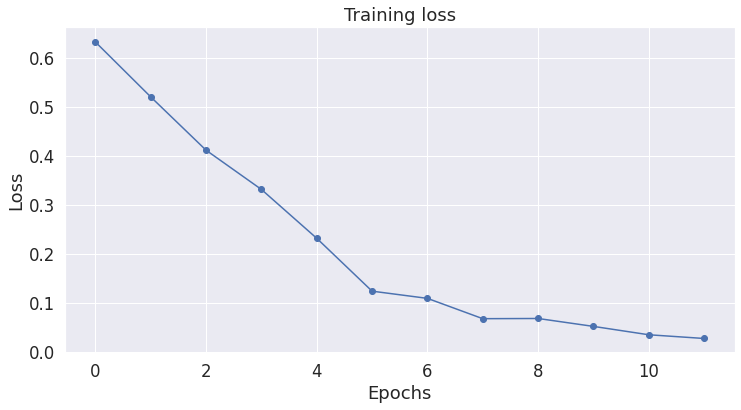

In [34]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

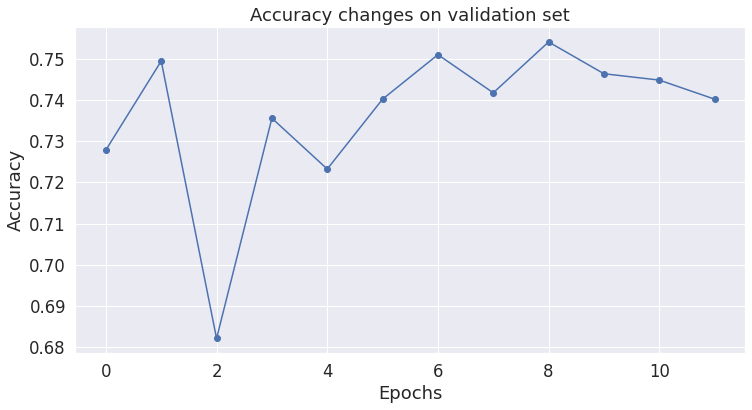

In [35]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve.
plt.plot(accuracy_values, 'b-o')

# Label the plot.
plt.title('Accuracy changes on validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [36]:
###################
#     Testing     #
###################
# After the completion of training, measure the performance on the testing set.
print('Testing on slovenian data...')

start_time = time.time()

# Put the model in evaluation mode - the dropout layers behave differently during evaluation.
model.eval()

# Tracking variables
test_accuracy = 0
num_of_batches = 0

print('Number of testing comments: {:,}'.format(len(test_inputs)))
# Evaluate data for one epoch.
for batch in test_dataloader:

  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from out dataloader
  batch_input_ids, batch_attention_mask, batch_labels = batch

  # Telling the model not to compute or store gradients, saves memory and speeds up validation
  with torch.no_grad():
      # Forward pass
      outputs = model(batch_input_ids, token_type_ids=None,
                      attention_mask=batch_attention_mask)
  
  # Get the "logits" output by the model, "logits" are the output values prior to applying an activation function
  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = batch_labels.to('cpu').numpy()

  # Calculate the accuracy for this batch of test sentences
  acc = flat_accuracy(logits, label_ids)

  # Accumulate the total accuracy
  test_accuracy += acc

  # Track the number of batches
  num_of_batches += 1

# Report the final accuracy for this testing run
accuracy = test_accuracy / num_of_batches
print('Accuracy: {0:.3f}'.format(accuracy))
print('Testing took: {:}'.format(format_time(time.time() - start_time)))
print('Testing done...')

Testing on slovenian data...
Number of testing comments: 646
Accuracy: 0.738
Testing took: 0:00:11
Testing done...


In [37]:
from sklearn.dummy import DummyClassifier

dummy_classifier_uniform = DummyClassifier(strategy='uniform', random_state=420)
dummy_classifier_stratified = DummyClassifier(strategy='stratified', random_state=420)

dummy_classifier_uniform.fit(np.array(train_inputs), np.array(train_labels))
dummy_classifier_stratified.fit(np.array(train_inputs), np.array(train_labels))

dummy_classifier_uniform.predict(np.array(test_inputs))
dummy_classifier_stratified.predict(np.array(test_inputs))

print('Accuracy on uniform dummy classifier: {:.3f}'.format(dummy_classifier_uniform.score(np.array(test_inputs), np.array(test_labels))))
print('Accuracy on stratified dummy classifier: {:.3f}'.format(dummy_classifier_stratified.score(np.array(test_inputs), np.array(test_labels))))


Accuracy on uniform dummy classifier: 0.492
Accuracy on stratified dummy classifier: 0.508


In [38]:
# Code to save the model to google drive
import os
from pytorch_pretrained_bert import WEIGHTS_NAME, CONFIG_NAME

OUTPUT_DIR = './drive/My Drive/Colab Notebooks/Bert models/Bert_migrants_slovenian/'

if not os.path.exists(OUTPUT_DIR):
  os.makedirs(OUTPUT_DIR)

print('Saving model to %s' % OUTPUT_DIR)

# If we have a distributed model, save only the encapsulated model
# (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
model_to_save = model.module if hasattr(model, 'module') else model

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(OUTPUT_DIR, WEIGHTS_NAME)
output_config_file = os.path.join(OUTPUT_DIR, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(OUTPUT_DIR)

print('Done saving...')

Saving model to ./drive/My Drive/Colab Notebooks/Bert models/Bert_migrants_slovenian/
Done saving...
